<b><font size=5><center>Рынок заведений общественного питания Москвы</center></font></b>

### Суть проекта

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

### Описание данных

Таблица `rest_data`:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

### Описание проекта

В ходе выполнения проекта мы получили и проверили данные. Исследовали соотношение видов объектов общественного питания по количеству, соотношение сетевых и несетевых заведений по количеству. Узнали, для какого вида объекта общественного питания характерно сетевое распространение и что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест. Для каждого вида объекта общественного питания описали среднее количество посадочных мест. Проверили, какой вид предоставляет в среднем самое большое количество посадочных мест. Построили график топ-10 улиц по количеству объектов общественного питания и нашли число улиц с одним объектом общественного питания, разбили по районам с использованием внешней информации. По итоговым данным подготовили презентацию.

### Извлечение данных

In [1]:
import pandas as pd                    # импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import seaborn as sns
import plotly.express as px 
from plotly import graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r"C:\Users\mi\Downloads\rest_data.csv")          # выгрузка датафрейма

data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
data.info()    # основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
data['object_name'] = data['object_name'].str.lower()
data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated().sum()  # проверка на дубликаты

85

Если привести все названия к нижнему регистру и откинуть id каждого объекта, можно найти 85 дубликатов. Зачистим их.

In [5]:
data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number'], inplace=True)
data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated().sum() # финальная проверка на пропуски

0

In [6]:
data.isna().sum() # проверка на пропуски

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Выгруженный датафрейм data состоит из 6 столбцов и 15366 строк. Пропусков и дубликатов в нем не обнаружено. Все типы данных в порядке. Столбцы датафрейма содержат следующую информацию:
    id — идентификатор объекта;
    object_name — название объекта общественного питания;
    chain — сетевой ресторан;
    object_type — тип объекта общественного питания;
    address — адрес;
    number — количество посадочных мест.

Проанализируем численные столбцы на аномальность

In [7]:
print(data['id'].max()) # максимальное и минимальное значение столбца с id
print(data['id'].min())

223439
838


In [8]:
print(data['number'].max()) # максимальное и минимальное значение столбца с количеством посадочных мест
print(data['number'].min())

1700
0


In [9]:
data.query('number == 1700') # проверка максимального значения посадочных мест

,id,object_name,chain,object_type,address,number
12723,199696,arena by soho family,нет,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700


Числовые значения в столбцах адекватные - нет отрицательных значений (что не допустимо). Максимальное значение в столбце с посадочными местами - 1700. Это достаточно много, но теоретически возможно и показалось подозрительным. При проверке выяснилось, что это большой бар для мероприятий. Так что все цифры в норме, диапазон адекватен, выбросов нет.

### Анализ данных

Исследуем соотношение видов объектов общественного питания по количеству. Построим график.

,object_type,id
0,кафе,6071
1,столовая,2584
2,ресторан,2282
3,предприятие быстрого обслуживания,1897
4,бар,855
5,буфет,576
6,кафетерий,395
7,закусочная,348
8,магазин (отдел кулинарии),273


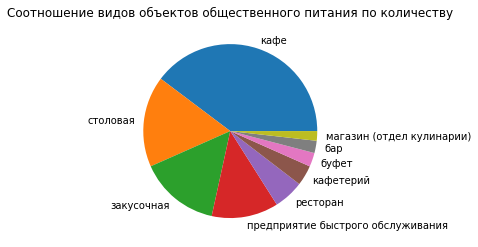

In [10]:
type_perc = data.groupby('object_type').agg({'id': 'count'}).sort_values(by='id', ascending=False).reset_index()
labels = list(data['object_type'].unique())
vals = type_perc['id']

display(type_perc)

plt.pie(vals, labels= labels)
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.show()

Больше всего в Москве кафе. Меньше всего магазинов и закусочных.

Исследуем соотношение сетевых и несетевых заведений по количеству. Построим график.

,chain,id
0,нет,12317
1,да,2964


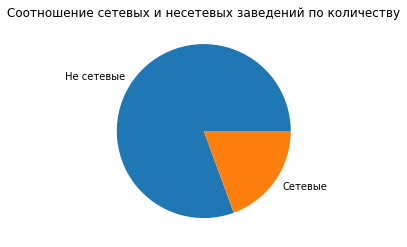

In [11]:
chain_perc = data.groupby('chain').agg({'id': 'count'}).sort_values(by='id', ascending=False).reset_index()
labels = ['Не сетевые', 'Сетевые']
vals = chain_perc['id']
display(chain_perc)

plt.pie(vals, labels=labels)
plt.title('Соотношение сетевых и несетевых заведений по количеству')
plt.show()

На рынке Москвы подавляющиее большинство заведений общепита - не сетевые

Выясним, для какого вида объекта общественного питания характерно сетевое распространение

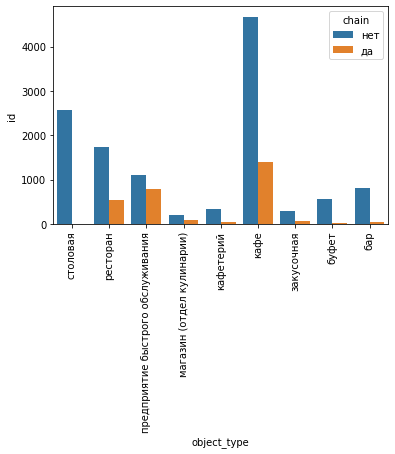

In [12]:
chain_data = data.groupby(['object_type', 'chain']).agg({'id': 'count'}).sort_values(by='object_type',  ascending=False).reset_index()

sns.barplot(x='object_type', y='id', hue='chain', data=chain_data)
plt.xticks(rotation=90)
plt.show()

Сетевое распространение более характерно для предприятий быстрого обслуживания.

Выясним, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест

[Text(0, 0.5, 'Заведения')]

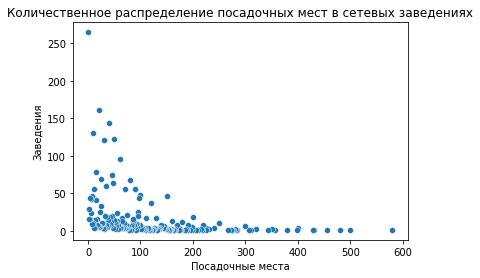

In [13]:
number_type = data.query('chain == "да"').groupby('number').agg({'id': 'count'}).sort_values(by='number',  ascending=False).reset_index()

ax = sns.scatterplot(x='number', y='id', data=number_type)
ax.set(title="Количественное распределение посадочных мест в сетевых заведениях")
ax.set(xlabel='Посадочные места')
ax.set(ylabel='Заведения')

Для сетевых заведений Москвы более характерно большое количество заведений с небольшим числом посадочных мест в каждом.

Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Посмотрим, какой вид предоставляет в среднем самое большое количество посадочных мест. Построим графики.

,object_type,number
0,столовая,130.337848
1,ресторан,96.884750
2,буфет,51.425347
3,бар,43.533333
4,кафе,39.785703
5,предприятие быстрого обслуживания,20.808645
6,кафетерий,9.184810
7,закусочная,7.847701
8,магазин (отдел кулинарии),5.589744


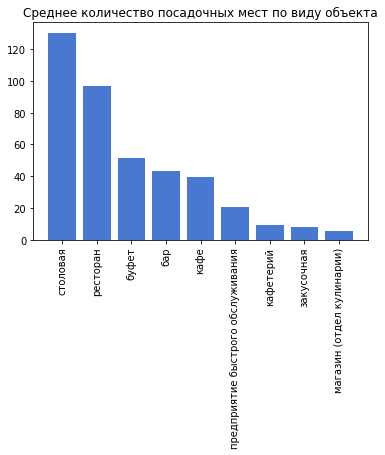

In [14]:
number_mean = data.groupby('object_type').agg({'number': 'mean'}).sort_values(by='number',  ascending=False).reset_index()
display(number_mean)

labels = list(number_mean['object_type'].unique())
vals = number_mean['number']

with plt.style.context('seaborn-muted'):
    plt.bar(labels, vals)
    plt.xticks(rotation=90)
    plt.title('Среднее количество посадочных мест по виду объекта')
    plt.show()

В среднем больше всего посадочных мест наблюдается в столовых и ресторанах.

Выделим в отдельный столбец информацию об улице из столбца address

In [15]:
data['street'] = data['address'].str.extract(r'(?:,\s+)(.+?)(?:,)')
data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией и узнаем, в каких районах Москвы находятся эти улицы

,street,number
0,город Зеленоград,232
1,проспект Мира,203
2,Профсоюзная улица,181
3,Ленинградский проспект,170
4,Пресненская набережная,167
5,Варшавское шоссе,161
6,Ленинский проспект,147
7,поселение Сосенское,137
8,проспект Вернадского,128
9,Кутузовский проспект,114


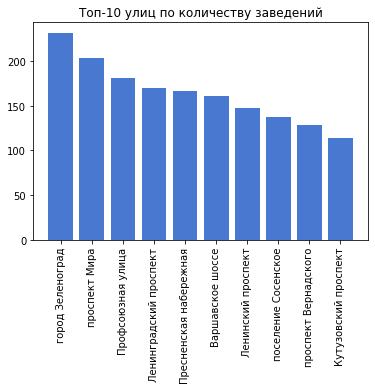

In [16]:
top_streets = data['street'].value_counts().sort_values(ascending=False).head(10).reset_index()
top_streets.columns = ['street', 'number']

display(top_streets)
labels = list(top_streets['street'])
vals = list(top_streets['number'])

with plt.style.context('seaborn-muted'):
    plt.bar(labels, vals)
    plt.xticks(rotation=90)
    plt.title('Топ-10 улиц по количеству заведений')
    plt.show()

Самыми "густонаселенными" оказались Зеленоград и проспект Мира

Изучим, в каких районах находятся данные улицы из ТОП-10. Для этого воспользуемся внешними данными

In [17]:
from io import BytesIO                                                       # импорт внешней таблицы с улицами и районами
import requests
spreadsheet_id = '1RUIl83reqwSD8vUlfERBW-VWwoWHn2Jj10c-UFuLMXY'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
areas = pd.read_csv(BytesIO(r.content))
areas['streetname'] = areas['streetname'].str.strip()
areas['area'] = areas['area'].str.strip()
areas['okrug'] = areas['okrug'].str.strip()
areas

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [18]:
top_10_area = top_streets.merge(areas[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname') # объединение датафреймов с топ-10 улиц и районами, в которых они пролегают
display(top_10_area.head())
top_10_area['area'].value_counts().head(10)

,street,number,streetname,okrug,area
0,город Зеленоград,232,город Зеленоград,Зеленоград,Район Крюково
1,город Зеленоград,232,город Зеленоград,Зеленоград,Район Матушкино-Савелки
2,город Зеленоград,232,город Зеленоград,Зеленоград,Панфиловский район
3,проспект Мира,203,проспект Мира,СВАО,Алексеевский район
4,проспект Мира,203,проспект Мира,СВАО,Ярославский Район


Район Теплый Стан             2
Ломоносовский район           2
Район Гагаринский             2
Район Тропарево-Никулино      2
Район Проспект Вернадского    2
Обручевский район             2
Донской район                 2
Район Крюково                 1
Район Нагатино-Садовники      1
Район Чертаново Северное      1
Name: area, dtype: int64

Больше всего улиц с наибольшим количеством заведений пролегает через районы Теплый Стан, Ломоносовский, Гагаринский, Тропарево-Никулино, Проспект Вернадского, Обручевский и Донской

Найдем число улиц с одним объектом общественного питания. Воспользуемся внешней информацией узнаем, в каких районах Москвы находятся эти улицы

In [19]:
one_inst_street = data['street'].value_counts().sort_values(ascending=False).reset_index()
one_inst_street.columns = ['street', 'number']
one_inst_street = one_inst_street.query('number == 1')
print('Число улиц с одним объектом общественного питания:', len(one_inst_street))

one_inst_street.head(10)

Число улиц с одним объектом общественного питания: 571


,street,number
1317,Петровско-Разумовская аллея,1
1318,2-й Щемиловский переулок,1
1319,Авиационный переулок,1
1320,2-й Полевой переулок,1
1321,улица Васильцовский Стан,1
1322,Иваньковское шоссе,1
1323,улица Щорса,1
1324,2-й Неопалимовский переулок,1
1325,Вербная улица,1
1326,поселение Филимонковское,1


Также объединим эту таблицу с данными о районах и посмотрим, какие районы наименее популярные

In [20]:
one_inst_street_area = one_inst_street.merge(areas[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname') # объединение датафреймов с топ-10 улиц и районами, в которых они пролегают
display(one_inst_street_area.head())
one_inst_street_area['area'].value_counts().head(10)


,street,number,streetname,okrug,area
0,Петровско-Разумовская аллея,1,Петровско-Разумовская аллея,САО,Район Аэропорт
1,2-й Щемиловский переулок,1,2-й Щемиловский переулок,ЦАО,Тверской район
2,Авиационный переулок,1,Авиационный переулок,САО,Район Аэропорт
3,2-й Полевой переулок,1,2-й Полевой переулок,ВАО,Район Сокольники
4,улица Васильцовский Стан,1,улица Васильцовский Стан,ЮВАО,Рязанский район


Таганский район        27
Район Хамовники        26
Басманный район        25
Тверской район         20
Пресненский район      19
Район Марьина роща     18
Район Арбат            17
Мещанский район        16
Район Сокольники       15
Район Замоскворечье    14
Name: area, dtype: int64

По числу улиц с одним заведением лидирую Таганский район, Хамовники и Басманный район. Данные районы расположены в центре. Такую статистику можно объяснить тем, что в этих районах много старых маленьких и коротких улочек, в которых будет трудно и нецелесообразно размещать много заведений, да и аренда там дорогая.

### Вывод

    В ходе выполнения проекта мы получили и проверили данные. Исследовали соотношение видов объектов общественного питания по количеству, соотношение сетевых и несетевых заведений по количеству. Узнали, для какого вида объекта общественного питания характерно сетевое распространение и что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест. Для каждого вида объекта общественного питания описали среднее количество посадочных мест. Проверили, какой вид предоставляет в среднем самое большое количество посадочных мест. Построили график топ-10 улиц по количеству объектов общественного питания и нашли число улиц с одним объектом общественного питания, разбили по районам с использованием внешней информации. По итоговым данным подготовили презентацию.
    В общем в Москве по соотношению видов преобладают кафе, столовые и рестораны, среди которых несетевых заведений - подавляющее большинство. Если рассматривать только сетевые заведения, то для них характерно большое количество заведений с небольшим числом посадочных мест в каждом, а также в них преобладают кафе, фастфуд и рестораны. Самое большое количество посадочных мест в среднем наблюдается в столовых, ресторанах и буфетах. Если рассматривать расположение изучаемых заведений, то по количеству мест общепита лидируют улицы Зеленограда и проспект Мира - берут площадью и протяженностью. В разрезе районов больше всего улиц с наибольшим количеством заведений пролегает через районы Теплый Стан, Ломоносовский, Гагаринский, Тропарево-Никулино, Проспект Вернадского, Обручевский и Донской. В то время, как самые "малонаселенные" районы (районы с самым большим количеством улиц, имеющих лишь одно заведение) - Таганский, Хамовники и Басманный. По полученным данным можно сделать вывод, что наилучший вариант для Москвы с точки зрения наименьшей конкуренции и наибольшей прибыли - это несетевой ресторан с большим количеством посадочных мест в Таганском районе.

Презентация: https://disk.yandex.ru/i/VphiI1obVmNVEQ